In [1]:
!pip install tensorflow-gpu==2.1.0

     |████████████████████████████████| 421.8 MB 5.1 kB/s 
     |████████████████████████████████| 3.8 MB 43.3 MB/s 
     |████████████████████████████████| 448 kB 56.3 MB/s 
     |████████████████████████████████| 50 kB 6.9 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=5c41611918a321c4ddcf886f75125c888a1c8f7a0726b479cafb2a1dffc4a9ad
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Succe

In [2]:
import tensorflow as tf 
tf.__version__

'2.1.0'

In [20]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop 
from tensorflow.keras.datasets import fashion_mnist 
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K

import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

In [9]:
def create_pairs(x, digit_indices):
 
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)



In [10]:
def create_pairs_on_set(images, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y

In [11]:
def show_image(image):
  plt.figure()
  plt.imshow(image)
  plt.colorbar()
  plt.grid(False)
  plt.show()


In [14]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images.astype("float32")
test_images = test_images.astype("float32")

train_images = train_images/255.0
test_images = test_images/255.0 

tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

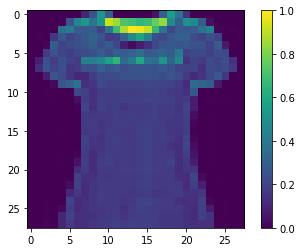

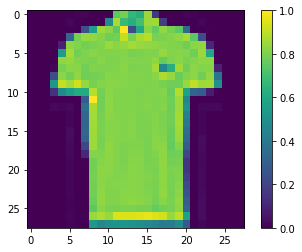

1.0


In [16]:
this_pair = 8 

show_image(ts_pairs[this_pair][0])
show_image(ts_pairs[this_pair][1])
print(ts_y[this_pair])

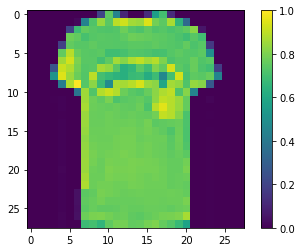

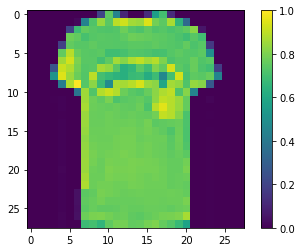

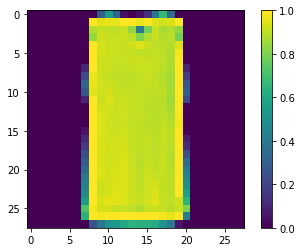

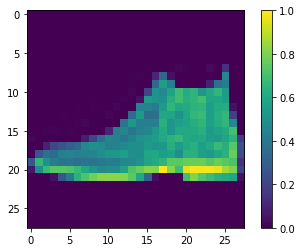

In [17]:
show_image(ts_pairs[:,0][0])
show_image(ts_pairs[:,0][1])

show_image(ts_pairs[:,1][0])
show_image(ts_pairs[:,1][1])

In [19]:
def initialize_base_network():
  input = Input(shape=(28,28,),name="base-unit")

  x = Flatten(name="Flatten_input")(input)

  x = Dense(128, activation="relu", name="first_base_dense")(x)

  x = Dropout(0.1, name="first_dropout")(x)

  x = Dense(128, activation="relu", name="second_base_dense")(x)

  x = Dropout(0.1, name="second_dropout")(x)

  x = Dense(128, activation="relu", name="third_base_dense")(x)

  
  return Model(inputs = input, outputs=x)

 
  

In [21]:
def euclidean_distance(vects):
  x, y = vects 

  sum_square = K.sum(K.square(x-y), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
  shape1, shape2 = shapes 

  return (shape1[0], 1)

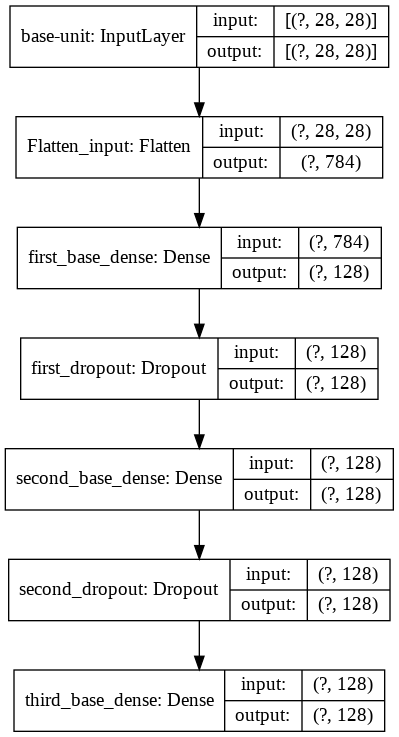

In [22]:
base_network = initialize_base_network()

plot_model(base_network, show_shapes=True, show_layer_names=True, to_file="base-model.png")

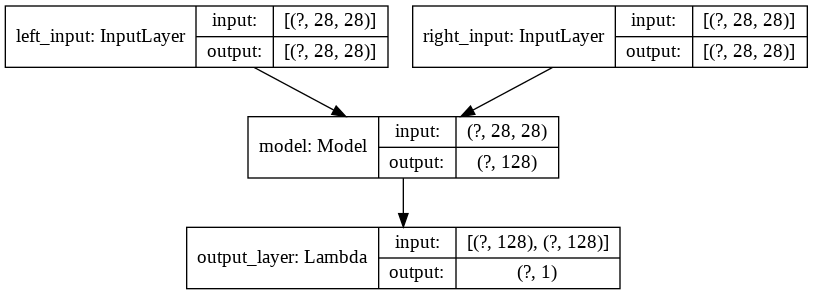

In [23]:
input_a = Input(shape=(28,28,),name="left_input")
vect_output_a = base_network(input_a)

input_b = Input(shape=(28,28,),name="right_input")
vect_output_b = base_network(input_b)

output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

model = Model([input_a, input_b], output)

plot_model(model, show_shapes=True, show_layer_names=True, to_file="outer_model.png")

In [24]:
def contrastive_loss_with_margin(margin):
  def constrastive_loss(y_true, y_pred):

    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return (y_true * square_pred + (1-y_true) * margin_square) 
  return constrastive_loss

In [26]:
rms = RMSprop()

model.compile(
    loss = contrastive_loss_with_margin(margin=1),
  optimizer = rms)


history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=20, batch_size=128, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

Train on 119980 samples, validate on 19980 samples
Epoch 1/20
119980/119980 [==============================] - 9s 76us/sample - loss: 0.1103 - val_loss: 0.0888
Epoch 2/20
119980/119980 [==============================] - 9s 73us/sample - loss: 0.0808 - val_loss: 0.0762
Epoch 3/20
119980/119980 [==============================] - 9s 71us/sample - loss: 0.0722 - val_loss: 0.0683
Epoch 4/20
119980/119980 [==============================] - 9s 72us/sample - loss: 0.0667 - val_loss: 0.0698
Epoch 5/20
119980/119980 [==============================] - 8s 70us/sample - loss: 0.0637 - val_loss: 0.0662
Epoch 6/20
119980/119980 [==============================] - 9s 72us/sample - loss: 0.0617 - val_loss: 0.0659
Epoch 7/20
119980/119980 [==============================] - 9s 73us/sample - loss: 0.0600 - val_loss: 0.0657
Epoch 8/20
119980/119980 [==============================] - 9s 71us/sample - loss: 0.0585 - val_loss: 0.0649
Epoch 9/20
119980/119980 [==============================] - 8s 69us/sample - 

In [27]:
def compute_accracy(y_true, y_pred):

  pred = y_pred.ravel() < 0.5 
  return np.mean(pred == y_true) 

In [28]:
loss = model.evaluate(x=[ts_pairs[:,0], ts_pairs[:,1]], y=ts_y)

y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])   

train_accuracy = compute_accracy(tr_y, y_pred_train) 

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])

test_accuracy = compute_accracy(ts_y, y_pred_test) 

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

19980/19980 [==============================] - 1s 46us/sample - loss: 0.0625
Loss = 0.062461983549889424, Train Accuracy = 0.9406651108518086 Test Accuracy = 0.915015015015015


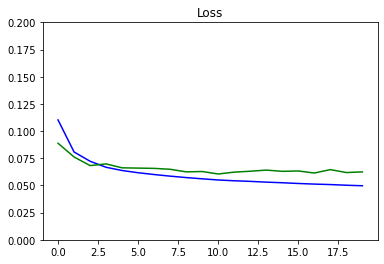

In [29]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='loss', title="Loss", ylim=0.2)

In [30]:
# Matplotlib config
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)



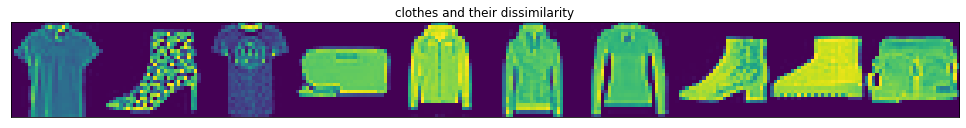

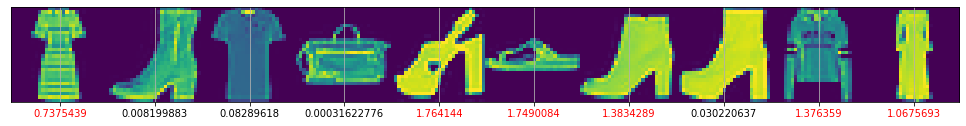

In [31]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_y[indexes], "clothes and their dissimilarity", 10)